# Mars orbital image (HiRISE) classifier

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2538136.svg)](https://doi.org/10.5281/zenodo.2538136)
Dataset by Gary Doran; Steven Lu; Lukas Mandrake; Kiri Wagstaff

Notebook by Leon Harper

https://data.nasa.gov/Space-Science/Mars-orbital-image-HiRISE-labeled-data-set-version/egmv-36wq

## Context
> This data set contains a total of 73,031 landmarks. 10,433 landmarks were detected and extracted from 180 HiRISE browse images, and 62,598 landmarks were augmented from 10,433 original landmarks. For each original landmark, we cropped a square bounding box that includes the full extent of the landmark plus a 30-pixel margin to left, right, top and bottom. Each cropped landmark was resized to 227x227 pixels, and then was augmented to generate 6 additional landmarks using the following methods:

> 1. 90 degrees clockwise rotation 
2. 180 degrees clockwise rotation
3. 270 degrees clockwise rotation
4. Horizontal flip
5. Vertical flip
6. Random brightness adjustment


Contents:
- map-proj-v3/: Directory containing individual cropped landmark images
- labels-map-proj-v3.txt: Class labels (ids) for each landmark image
- landmarks_map-proj-v3_classmap.csv: Dictionary that maps class ids to semantic names



### Class discussion
> We give a discussion of the various landmarks that make up our classes. 
Bright dune and dark dune are two sand dune classes found on Mars. Dark dunes are completely defrosted, whereas bright dunes are not. Bright dunes are generally bright due to overlying frost and can exhibit black spots where parts of the dune are defrosting.

> The crater class consists of crater images in which the diameter of the crater is greater than or equal to 1/5 the width of the image and the circular rim is visible for at least half the crater's circumference.

> The slope streak class consists of images of dark flow-like features on slopes. These features are believed to be formed by a dry process in which overlying (bright) dust slides down a slope and reveals a darker sub-surface.

> Impact ejecta refers to material that is blasted out from the impact of a meteorite or the eruption of a volcano. We also include cases in which the impact cleared away overlying dust, exposing the underlying surface. In some cases, the associated crater may be too small to see. Impact ejecta can also include lava that spilled out from the impact (blobby ("lobate") instead of blast-like), more like an eruption (triggered by the impact). Impact ejecta can be isolated, or they can form in clusters when the impactor breaks up into multiple fragments.

> Spiders and Swiss cheese are phenomena that occur in the south polar region of Mars. Spiders have a central pit with radial troughs, and they are believed to form as a result of sublimation of carbon dioxide ice. This process can produce mineral deposits on top, which look like dark or light dust that highlights cracks in the CO2 ice.  Spiders can resemble impact ejecta due to their radial troughs, but impact ejecta tends to have straight radial jets that fade as they get farther from the center.  The spider class also includes fan-like features that form when a geyser erupts through the CO2 layer and the material is blown by the wind away from the cracks. Fans are typically unidirectional (following the wind direction), whereas impact ejecta often extends in multiple directions. Swiss cheese is a terrain type that consists of pits that are formed when the sun heats the ice making it sublimate (change solid to gas).

> Other is a catch-all class that contains images that fit none of the defined classes of interest. This class makes up the majority of our data set.

Augmented images are designated with words like "fv" or "brt". This notebook uses a simple CNN to classify landmark images that were detected and extracted from HiRISE browse images. The original dataset was 10,815 landmarks that were then cropped to a bounding box with a 30 pixel margin on all sides. Each landmark is resized to 227x227 pixels which saves preprocessing time.

# Setup

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, optimizers as op
import os
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import tensorflow as tf
import visualkeras

SEED = 42
TEST_PROP = 0.25
IMAGE_SHAPE = (227, 227)
BASE_PATH = "hirise-map-proj-v3_2/"
IMAGES_PATH = BASE_PATH + "map-proj-v3_2/"
BATCH_SIZE = 32
RANDOM_STATE = 42

In [ ]:
devices = tf.config.list_physical_devices('GPU')
if len(devices) == 0: print("Please install the latest TensorFlow GPU release.")
devices

In [25]:
!nvidia-smi

Mon Jul 31 12:53:09 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070        Off | 00000000:01:00.0  On |                  N/A |
| 33%   56C    P2              50W / 185W |   7766MiB /  8192MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

This code detects if a GPU is present and it displays details about the GPU such as video memory. Please use a GPU to speed up training.

## Dataset creation

In [26]:
labels_df = pd.read_csv(BASE_PATH + "labels-map-proj_v3_2_train_val_test.csv", sep=" ")
labels_df['class'] = labels_df['class'].astype('string')
labels_df

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


In [27]:
labels_df[labels_df.duplicated()]

,name,class,split
2044,ESP_013049_0950_RED-0067.jpg,7,train
2045,ESP_013049_0950_RED-0067-fv.jpg,7,train
2046,ESP_013049_0950_RED-0067-brt.jpg,7,train
2047,ESP_013049_0950_RED-0067-r90.jpg,7,train
2048,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
52621,ESP_012652_0950_RED-0003-brt.jpg,6,val
52622,ESP_012652_0950_RED-0003-r90.jpg,6,val
52623,ESP_012652_0950_RED-0003-r180.jpg,6,val
52624,ESP_012652_0950_RED-0003-r270.jpg,6,val


In [28]:
labels_df = labels_df.drop_duplicates()
labels_df

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


We use a labels csv file to get the file names, classes and a relevant split.

In [29]:
train_df = labels_df[labels_df['split'] == 'train']
val_df = labels_df[labels_df['split'] == 'val']
test_df = labels_df[labels_df['split'] == 'test']

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    shuffle=True,
    color_mode="grayscale",
    stratify=True
)


val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    color_mode="grayscale",
)

Found 48979 validated image filenames belonging to 8 classes.
Found 14175 validated image filenames belonging to 8 classes.


This code utilises the ImageDataGenerator to rescale the pixels for each image and we collect all of the images according to their file names and relevant split. We use a separate generator as the validation split has already been applied for us.

## Preliminary EDA

In [30]:
class_map = pd.read_csv(BASE_PATH + "classmap.csv", header=None, index_col=0) \
            .squeeze("columns") \
            .to_dict()
class_map

{0: 'other',
 1: 'crater',
 2: 'dark dune',
 3: 'slope streak',
 4: 'bright dune',
 5: 'impact ejecta',
 6: 'swiss cheese',
 7: 'spider'}

This class map describes how encoded classes correspond to their original string values.

<Axes: xlabel='class', ylabel='count'>

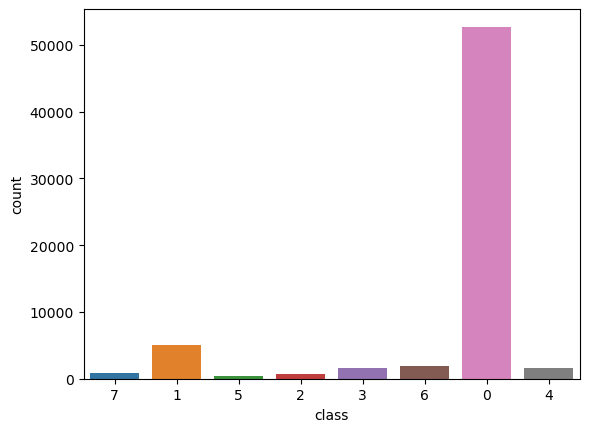

In [31]:
sns.countplot(x=labels_df['class'])

Most of the images are in the "other" category as described by the dataset authors.

In [32]:
labels_df['class'].value_counts()

0    52722
1     5024
6     1834
4     1654
3     1575
7      896
2      766
5      476
Name: class, dtype: Int64

In [33]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64947 entries, 0 to 67809
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    64947 non-null  object
 1   class   64947 non-null  string
 2   split   64947 non-null  object
dtypes: object(2), string(1)
memory usage: 2.0+ MB


In [34]:
aug_tags = ["brt", "fv", "r90", "r180", "r270", "fh"]

aug_mask = '|'.join(aug_tags)

original_landmarks_df = labels_df[~labels_df['name'].str.contains(aug_mask)]
original_landmarks_df

,name,class,split
0,ESP_013049_0950_RED-0067.jpg,7,train
7,ESP_019697_2020_RED-0024.jpg,1,train
14,ESP_015962_1695_RED-0016.jpg,1,train
21,ESP_013049_0950_RED-0118.jpg,7,train
28,ESP_015962_1695_RED-0017.jpg,1,train
...,...,...,...
67805,ESP_018707_2205_RED-0041.jpg,0,test
67806,ESP_018707_2205_RED-0062.jpg,0,test
67807,ESP_018707_2205_RED-0105.jpg,0,test
67808,ESP_018707_2205_RED-0058.jpg,0,test


I am not entirely sure why the original dataset description said 10,433 landmarks instead of 10,815 landmarks but this seems to be about right.

## Model building

In [35]:
model = keras.Sequential([
    layers.Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(227,227,1)),
    layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(2,2),
    
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(len(class_map), activation='softmax'),
])

optimizer = keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

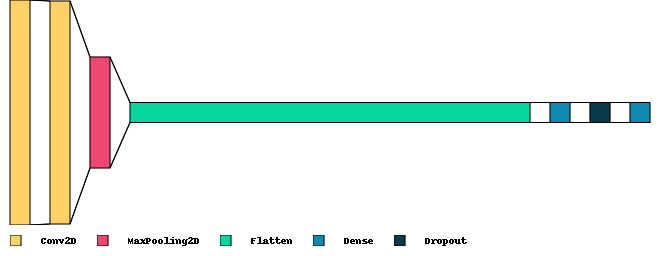

In [36]:
visualkeras.layered_view(model, scale_xy=1,legend=True, draw_volume=False, spacing=20)

We create a CNN using two convolutional layers with a filter size of 32 where they take in an input_shape of (227,227). We then flatten the inputs to be fed into two dense layers and we finally have a softmax output layer. I use an Adam optimizer as that is the conventional optimizer and I use accuracy + categorical crossentropy as my metrics.

In [37]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
history = model.fit(train_gen, validation_data=val_gen, epochs=5, callbacks=[early_stopping_cb])

Epoch 1/5
1531/1531 [==============================] - 56s 36ms/step - loss: 0.8214 - accuracy: 0.8153 - val_loss: 0.8549 - val_accuracy: 0.7916
Epoch 2/5
1531/1531 [==============================] - 54s 35ms/step - loss: 0.7299 - accuracy: 0.8172 - val_loss: 0.8179 - val_accuracy: 0.7916
Epoch 3/5
1531/1531 [==============================] - 54s 35ms/step - loss: 0.6777 - accuracy: 0.8197 - val_loss: 0.8007 - val_accuracy: 0.7994
Epoch 4/5
1531/1531 [==============================] - 54s 35ms/step - loss: 0.6364 - accuracy: 0.8279 - val_loss: 0.7831 - val_accuracy: 0.8015
Epoch 5/5
1531/1531 [==============================] - 55s 36ms/step - loss: 0.5823 - accuracy: 0.8379 - val_loss: 0.7596 - val_accuracy: 0.8018


To save on training time, I have used an early stopping callback function that monitors the validation accuracy to see if accuracy doesn't improve over time.

<Axes: >

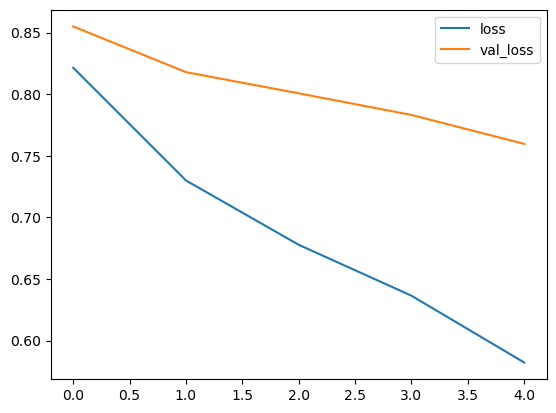

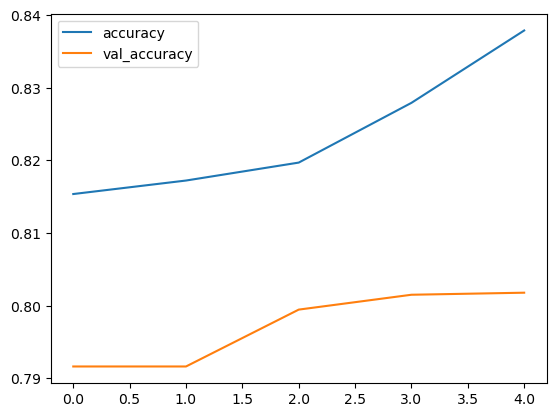

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

Whilst the training accuracy improves, the validation accuracy isn't improving at the same rate which implies overfitting

In [42]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGES_PATH,
    x_col="name",
    y_col="class",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=RANDOM_STATE,
    has_ext=True,
    shuffle=True,
    color_mode="grayscale",
    stratify=True
)

loss, accuracy = model.evaluate(test_gen, batch_size=BATCH_SIZE)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

Found 1793 validated image filenames belonging to 8 classes.
57/57 [==============================] - 1s 17ms/step - loss: 0.6712 - accuracy: 0.8321
Loss:  0.6712139844894409
Accuracy:  0.8321249485015869


According to the results from the test dataframe, the accuracy is 82.6%. However, we will later see that the F1 score is 74% which is a more reliable metric to use as it accounts for an unbalanced dataset

57/57 [==============================] - 1s 17ms/step
F1 Score:  0.74


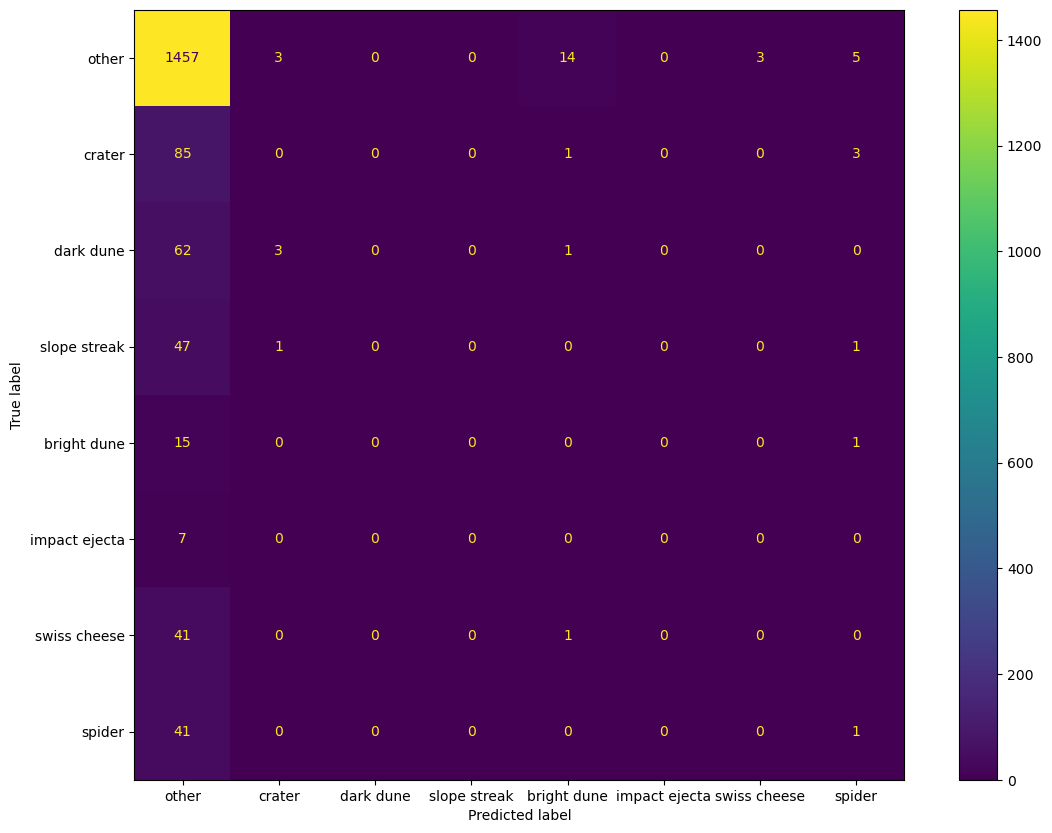

In [43]:
y_pred = model.predict(test_gen)
y_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

f1 = f1_score(y_true_labels, y_labels, average='weighted')

fig, ax = plt.subplots(figsize=(14,10))

cm = confusion_matrix(y_true_labels, y_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_map.values()))
print("F1 Score: ", round(f1, 2))
disp.plot(ax=ax)
plt.show()

Since this is an unbalanced dataset, it is unsurprising that most of the classifications end up being "other".

In [44]:
model.save("./mars_classifier.keras")